## Setup

All libraries that are used throughout the code.

In [9]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install keras
%pip install tensorflow
%pip install plotly_express
%pip install nltk
%pip install gensim
%pip install gdown
%pip install fasttext
%pip install imbalanced-learn
%pip install nltk pandas
%pip install pickle-mixin

  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5991 sha256=0ab7427b72def6dcdfc67c713db0977dd337402f0933f43a8398862b4b5347e5
  Stored in directory: /root/.cache/pip/wheels/3e/c6/e9/d1b0a34e1efc6c3ec9c086623972c6de6317faddb2af0a619c
Successfully built pickle-mixin


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, cohen_kappa_score, confusion_matrix
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import fasttext

In [13]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# FastText + SVM




In this approach, we combine the power of the FastText model for word representation with the effectiveness of the SVM classifier to perform sentiment classification on Uber comments. FastText allows capturing rich semantic information, while SVM is adept at finding patterns in high-dimensional spaces. Together, these models can process comments, extract their semantic features, and classify their sentiments accurately. Training is performed by tuning the hyperparameters of FastText and SVM, followed by evaluating the model's performance using metrics such as precision, recall, and F1-score. This combination provides an effective way to understand and classify the sentiments expressed by users in Uber comments.


In this section, we delve into advanced techniques to enhance the performance of our text classification model using FastText combined with Support Vector Machines (SVM). We explore the utilization of Hierarchical Softmax (HS) in FastText, the incorporation of word bigrams for improved feature representation, and the significance of performing text preprocessing within the FastText+SVM pipeline.

1. Hierarchical Softmax:
Hierarchical Softmax is a specialized loss function utilized in FastText for more efficient training and prediction processes. Unlike traditional softmax, which computes probabilities for each label independently, Hierarchical Softmax organizes labels into a hierarchical structure, significantly reducing the computational complexity by efficiently traversing the label hierarchy during training and prediction. This enables faster training and inference, particularly beneficial when dealing with large datasets and numerous labels.

2. Utilizing Word Bigrams:
Incorporating word bigrams, sequences of two adjacent words, allows our model to capture more contextual information and linguistic nuances present in the text data. By considering word pairs instead of individual words, the model gains a richer understanding of language patterns and dependencies, leading to enhanced classification accuracy, especially in tasks where the order of words is crucial, such as sentiment analysis and document categorization.

3. Preprocessing Within FastText+SVM Section:
While the notebook initially includes text preprocessing steps, we opt to integrate the preprocessing directly into the FastText+SVM pipeline. By doing so, we ensure consistency in the preprocessing techniques applied across the entire workflow. Additionally, embedding preprocessing within the training pipeline facilitates seamless model deployment and reduces the complexity of managing multiple preprocessing steps independently. This streamlined approach improves code readability, maintainability, and scalability of the classification system.



This function preprocesses the input text by converting it to lowercase, removing punctuation and numbers, tokenizing the text, and removing stop words using NLTK.


**Function Upload:** The upload function loads data from a specified CSV file and returns it as a pandas DataFrame.



In [14]:
def upload(file_path):
    """
    Load data from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded data.
    """
    return pd.read_csv(file_path, sep=";")


**Function preprocess:** The preprocess function performs several text preprocessing steps: converting to lowercase, removing punctuation and numbers, tokenizing the text, and removing stopwords.

In [15]:
def preprocess(text):
    """
    Preprocess text by converting to lowercase, removing punctuation,
    removing numbers, tokenizing, and removing stopwords.

    Args:
        text (str): Text to be preprocessed.

    Returns:
        str: Preprocessed text.
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


**Function vectorize:** The vectorize function converts preprocessed text into a vector representation using a trained FastText model.

In [16]:
def vectorize(text, model):
    """
    Convert text to a vector using FastText.

    Args:
        text (str): Text to be converted into a vector.
        model (fasttext.FastText._FastText): Trained FastText model.

    Returns:
        np.ndarray: Vector representing the text.
    """
    words = text.split()
    word_vectors = [model.get_word_vector(word) for word in words]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.get_dimension())


**Function predict:** The predict function uses GridSearchCV to find the best hyperparameters for an SVM model and then makes predictions on the test set using the best model.

In [17]:
def predict(model, X_train, y_train, X_test, params):
    """
    Perform prediction using SVM with GridSearchCV.

    Args:
        model (SVC): SVM model.
        X_train (np.ndarray): Training data.
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Test data.
        params (dict): Parameters for GridSearchCV.

    Returns:
        np.ndarray: Predictions on the test set.
        SVC: Best estimator found by GridSearchCV.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print("Best parameters found by GridSearchCV:")
    print(grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    return y_pred, best_model


**Function calculate_youden_index:** The calculate_youden_index function calculates Youden's Index for a multi-class classification problem using the confusion matrix.

In [18]:
def calculate_youden_index(conf_matrix):
    """
    Calculate Youden's Index for multi-class classification.

    Args:
        conf_matrix (ndarray): Confusion matrix.

    Returns:
        float: Average Youden's Index.
    """
    num_classes = conf_matrix.shape[0]
    youden_index = 0.0
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fn = np.sum(conf_matrix[i, :]) - tp
        fp = np.sum(conf_matrix[:, i]) - tp
        tn = np.sum(conf_matrix) - (tp + fn + fp)
        sensitivity = tp / (tp + fn) if tp + fn > 0 else 0
        specificity = tn / (tn + fp) if tn + fp > 0 else 0
        youden_index += (sensitivity + specificity - 1)
    return youden_index / num_classes


**Function results:** The results function calculates and displays various performance metrics and the confusion matrix for the predictions made by the model.

In [29]:
def results(y_test, y_pred, labels):
    """
    Display prediction results.

    Args:
        y_test (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        labels (list): List of labels.
    """
    accuracy_test = accuracy_score(y_test, y_pred)
    precision_test = precision_score(y_test, y_pred, average='weighted')
    recall_test = recall_score(y_test, y_pred, average='weighted')
    f1_score_test = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    cohen_kappa_test = cohen_kappa_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    youden_index_test = calculate_youden_index(conf_matrix)

    print("\nPerformance metrics on test data:")
    print(f'Accuracy: {accuracy_test}')
    print(f'Precision: {precision_test}')
    print(f'Recall: {recall_test}')
    print(f'F1-score: {f1_score_test}')
    print(f'Cohen Kappa: {cohen_kappa_test}')
    print(f'Youden\'s Index: {youden_index_test}')

    plt.figure(figsize=(10, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

**Function save_model:** The save_model function saves the trained SVM model to a file using pickle.

In [23]:
def save_model(model, filename):
    """
    Save the trained model using pickle.

    Args:
        model (SVC): Trained model.
        filename (str): Filename to save the model.
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


This section orchestrates the entire workflow:


1.   Load Data: Calls the upload function to load the dataset.
2. Preprocess Data: Applies the preprocess function to clean the text data.
3. Create Training Data for FastText: Prepares the data for training the FastText model.
4. Train FastText Model: Trains the FastText model and saves it.
5. Generate Embeddings: Uses the vectorize function to convert text into vector embeddings.
6. Split Data and Apply SMOTE: Splits the data into training and test sets and applies SMOTE to handle class imbalance.
7. Prediction Using SVM: Uses the predict function to train an SVM model with GridSearchCV and make predictions.
8. Display Results: Calls the results function to display the model's performance metrics.
9. Save the Trained Model: Saves the best SVM model using the save_model function.



Best parameters found by GridSearchCV:
{'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Performance metrics on test data:
Accuracy: 0.9305555555555556
Precision: 0.9331520118175445
Recall: 0.9305555555555556
F1-score: 0.9305852156766241
Cohen Kappa: 0.8398598773927186
Youden's Index: 0.8682861804439477


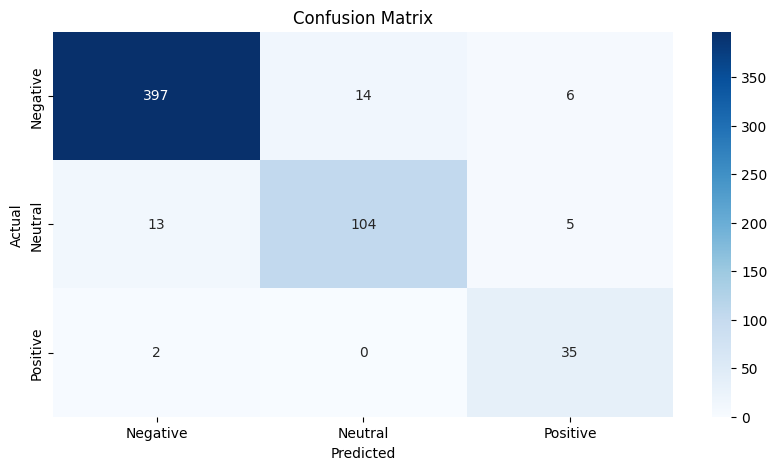

In [30]:
def main():
    """
    Main execution pipeline: load data, preprocess, vectorize, train model, predict, evaluate and save the model.
    """
    # Load Data
    dataset = upload("classification-labeled.csv")
    texts = [preprocess(text) for text in dataset['comment'].tolist()]
    labels = [f'__label__{label}' for label in dataset['sentiment'].tolist()]

    # Create training data for FastText
    train_data_path = 'train_data.txt'
    with open(train_data_path, 'w', encoding='utf-8') as f:
        for text, label in zip(texts, labels):
            f.write(f'{label} {text}\n')

    # Train FastText model
    fasttext_model = fasttext.train_supervised(input=train_data_path, lr=1.0, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='hs')
    fasttext_model.save_model('fasttext_model_hs.bin')

    # Generate Embeddings
    X = [vectorize(text, fasttext_model) for text in texts]
    y = [int(label.replace('__label__', '')) for label in labels]

    # Split data and apply SMOTE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Prediction using SVM
    svm_classifier = SVC()
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }
    y_pred_test, best_svm_classifier = predict(svm_classifier, X_train_resampled, y_train_resampled, X_test, param_grid)

    # Display Results
    results(y_test, y_pred_test, labels)

    # Save the trained model
    save_model(best_svm_classifier, 'svm_model.pkl')

if __name__ == "__main__":
    main()